# Import Data

In [1]:
#Import stuff
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, f1_score
from sklearn.neighbors import DistanceMetric
import warnings
import gower
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import inspect
import matplotlib.pyplot as plt
from sklearn import metrics
from keras import backend as K
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import plot_tree
from sklearn import tree
    

def recall_m(y_true, y_pred): # TPR
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) # TP
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1))) # P
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) # TP
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1))) # TP + FP
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
    
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def f1_m2(y_true, y_pred):
    return f1_score(y_true, y_pred)
    #precision = precision_m(y_true, y_pred)
    #recall = recall_m(y_true, y_pred)
    #return 2*((precision*recall)/(precision+recall+K.epsilon()))

def TP(y_true, y_pred):
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) # TP
    y_pos = K.round(K.clip(y_true, 0, 1))
    n_pos = K.sum(y_pos)
    y_neg = 1 - y_pos
    n_neg = K.sum(y_neg)
    n = n_pos + n_neg
    return tp/n

def TN(y_true, y_pred):
    y_pos = K.round(K.clip(y_true, 0, 1))
    n_pos = K.sum(y_pos)
    y_neg = 1 - y_pos
    n_neg = K.sum(y_neg)
    n = n_pos + n_neg
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos
    tn = K.sum(K.round(K.clip(y_neg * y_pred_neg, 0, 1))) # TN
    return tn/n

def FP(y_true, y_pred):
    y_pos = K.round(K.clip(y_true, 0, 1))
    n_pos = K.sum(y_pos)
    y_neg = 1 - y_pos
    n_neg = K.sum(y_neg)
    n = n_pos + n_neg
    tn = K.sum(K.round(K.clip(y_neg * y_pred, 0, 1))) # FP
    return tn/n

def FN(y_true, y_pred):
    y_pos = K.round(K.clip(y_true, 0, 1))
    n_pos = K.sum(y_pos)
    y_neg = 1 - y_pos
    n_neg = K.sum(y_neg)
    n = n_pos + n_neg
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos
    tn = K.sum(K.round(K.clip(y_true * y_pred_neg, 0, 1))) # FN
    return tn/n

In [2]:
import tensorflow as tf

In [3]:
#accuracy after each batch
class BCP(tf.keras.callbacks.Callback):
    batch_accuracy = [] # accuracy at given batch
    batch_f1 = [] # f1 at given batch
    
    def __init__(self):
        super(BCP,self).__init__() 
        
    def on_train_batch_end(self, batch, logs=None):
        BCP.batch_accuracy.append(logs.get('accuracy'))
        BCP.batch_f1.append(logs.get('f1_m'))
        


In [4]:
#accuracy after each batch
class BCP2(tf.keras.callbacks.Callback):
    batch_accuracy = [] # accuracy at given batch
    batch_f1 = [] # f1 at given batch
    batch_f1_val = [] # f1 of validation at given batch
    
    def __init__(self, val_data):
        super(BCP,self).__init__() 
        self.validation_data = val_data
        
    def on_train_batch_end(self, batch, logs=None):
        x_val = self.validation_data[0]
        y_val_true = self.validation_data[1]
        y_val_pred = self.model.predict(x_val, verbose=0)
        
        print(vars(self))
        print(vars(batch))
        print(vars(logs))
        
        y_val_class = [0 if val < .5 else 1 for val in y_val_pred]
        batchF1 = f1_m2(y_val_true, y_val_class)
        
        BCP.batch_f1_val.append(batchF1)
        BCP.batch_accuracy.append(logs.get('accuracy'))
        BCP.batch_f1.append(logs.get('f1_m'))

In [5]:
def evalNN(thresh, pred, ytest):
    plotROC(pred, ytest)
    classPred = [0 if val < thresh else 1 for val in pred]
    evaluate(ytest, classPred, thresh)

def thresh(pred, ytest):
    bestacc = 0
    besttp = 0
    bestf1 = 0
    bestthresh = 0
    accList = []
    tpList = []
    f1list = []
    threshlist = []
    for i in range(1,100):
        classPred = [0 if val < (i/100) else 1 for val in pred]
        accuracy = accuracy_score(ytest, classPred)
        tpr = recall_score(ytest, classPred)
        f1 = f1_score(ytest, classPred)
        accList.append(accuracy)
        tpList.append(tpr)
        f1list.append(f1)
        threshlist.append(i)
        if (f1>bestf1):
            bestacc= accuracy
            besttp = tpr
            bestf1 = f1
            bestthresh=i
            
    plt.plot(threshlist, accList, 'b', label='Accuracy')
    plt.plot(threshlist, tpList, 'r', label='Recall')
    plt.plot(threshlist, f1list, 'g', label='F1 score')
    plt.axvline(x = bestthresh, color = 'k', label = 'Best threshold')
    plt.title('Threshold Graph')
    plt.xlabel('Threshold')
    plt.ylabel('Metric Value')
    plt.legend()
    plt.show()

    return (bestthresh/100)

def plotNN(history):
    # Extract accuracy and TPR values from the training history
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    f1 = history.history['f1_m']
    val_f1 = history.history['val_f1_m']
    epochs = range(1, len(accuracy) + 1)

    # Plot the accuracy values
    plt.plot(epochs, accuracy, 'b', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
    
    # Plot the recall values
    plt.plot(epochs, f1, 'k', label='Training f1')
    plt.plot(epochs, val_f1, 'c', label='Validation f1')

    plt.title('Training and Validation Metrics')
    plt.xlabel('Epochs')
    plt.ylabel('Metric Value')
    plt.legend()
    plt.show()

def BiggerNN(df, test):
    # Define the model architecture
    model = Sequential()
    model.add(Dense(512, activation='relu', input_dim=30))
    model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy',
                  metrics=['accuracy', f1_m])
    
    xtrain = df[xColumns]
    ytrain = df["Churn_Yes"]
    
    xtest = test[xColumns]
    ytest = test["Churn_Yes"]
    
    BCP.batch_accuracy.clear()
    BCP.batch_f1.clear()
    
    val_data = (xtest, ytest)
    
    history = model.fit(xtrain, ytrain, epochs=200, batch_size=32, shuffle=True, 
                        validation_data=val_data, callbacks = [BCP()], verbose=0)
    
    plt.plot(range(len(BCP.batch_f1)), BCP.batch_f1, 'r', label='F1')
    plt.title('Batch F1 Graph')
    plt.xlabel('Batch')
    plt.ylabel('F1')
    plt.legend()
    plt.show()
    
    plotNN(history)
    
    print("########################   TRAIN   ########################")
    pred = model.predict(xtrain)
    threshold = thresh(pred, ytrain)
    evalNN(threshold, pred, ytrain)
    
    
    print("\n\n\n########################   TEST   ########################")
    pred = model.predict(xtest)
    evalNN(threshold, pred, ytest)
    
def plotROC(prob, ytest):
    fpr, tpr, _ = metrics.roc_curve(ytest,  prob)
    auc = metrics.roc_auc_score(ytest, prob)
    #create ROC curve
    plt.plot(fpr,tpr,label="AUC="+str(auc))
    plt.title('ROC and AUC')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()
    
def findClosest(num):
    i = (notSBD['Prob'] - num).abs().idxmin()
    row = notSBD.loc[i]
    notSBD.drop(i, inplace=True)
    return row

def evaluate(acc, pred, bestthresh):
    cm = confusion_matrix(acc, pred)
    bestacc = accuracy_score(acc, pred)
    besttp = recall_score(acc, pred)
    bestf1 = f1_score(acc, pred)
    
    print("Confusion Matrix:")
    print(cm)
    print("Best Threshold:", bestthresh)
    print("Accuracy:", bestacc)
    print("Recall:", besttp)
    print("F1:", bestf1)


    

def dist(df):
    yes = len(df[df["Churn_Yes"] == 1])
    no = len(df[df["Churn_Yes"] == 0])
    print("Churn Yes:", yes)
    print("Churn No:", no)
    return (yes, no)

In [6]:
#read data
churn = pd.read_csv(r"C:\Users\21sla\OneDrive - Dickinson College\Data300\WA_Fn-UseC_-Telco-Customer-Churn.csv")
print("Before:", len(churn))
churn = churn.dropna(how= 'any', axis=0)
print("After:", len(churn))
#churn.head(5)
churn.dtypes

Before: 7043
After: 7043


customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [7]:
#Drop ID
clean = churn.drop("customerID", axis=1)

#Remove missing values
clean.replace(' ', np.nan, inplace=True)
print("Before:", len(clean))
clean = clean.dropna(how= 'any', axis=0)
print("After:", len(clean))

#set data types
clean["TotalCharges"] = clean["TotalCharges"].astype(float)
clean["SeniorCitizen"] = clean["SeniorCitizen"].astype(object)


Before: 7043
After: 7032


In [8]:
#Make dummies
dummies = pd.get_dummies(clean, drop_first= True)
clean = dummies
clean.dtypes

C:\Users\21sla\AppData\Local\Temp\ipykernel_2680\4219534775.py:2: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  dummies = pd.get_dummies(clean, drop_first= True)


tenure                                     int64
MonthlyCharges                           float64
TotalCharges                             float64
gender_Male                                uint8
SeniorCitizen_1                            uint8
Partner_Yes                                uint8
Dependents_Yes                             uint8
PhoneService_Yes                           uint8
MultipleLines_No phone service             uint8
MultipleLines_Yes                          uint8
InternetService_Fiber optic                uint8
InternetService_No                         uint8
OnlineSecurity_No internet service         uint8
OnlineSecurity_Yes                         uint8
OnlineBackup_No internet service           uint8
OnlineBackup_Yes                           uint8
DeviceProtection_No internet service       uint8
DeviceProtection_Yes                       uint8
TechSupport_No internet service            uint8
TechSupport_Yes                            uint8
StreamingTV_No inter

In [9]:
"""from sklearn.preprocessing import StandardScaler


# Select the numerical columns to be standardized
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the selected columns
clean[numerical_cols] = scaler.fit_transform(clean[numerical_cols])"""

"from sklearn.preprocessing import StandardScaler\n\n\n# Select the numerical columns to be standardized\nnumerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']\n\n# Initialize the StandardScaler\nscaler = StandardScaler()\n\n# Fit and transform the selected columns\nclean[numerical_cols] = scaler.fit_transform(clean[numerical_cols])"

# Log Model

In [10]:
x = clean.drop('Churn_Yes', axis=1)
y = clean['Churn_Yes']

In [11]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=42)

#xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2)

In [12]:
xtrain.head(5)

,tenure,MonthlyCharges,TotalCharges,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
6030,43,49.05,2076.20,0,0,0,0,0,1,0,...,0,1,0,1,0,0,1,0,0,0
3410,3,53.40,188.70,1,0,0,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0
5483,55,77.75,4458.15,0,0,1,0,1,0,1,...,0,0,0,0,0,0,1,0,1,0
5524,45,54.65,2553.70,1,0,1,1,1,0,0,...,0,0,0,0,0,1,0,0,0,0
6337,55,100.90,5448.60,0,0,1,1,1,0,1,...,0,1,0,1,1,0,0,0,0,1


In [13]:
xtest.head(5)

,tenure,MonthlyCharges,TotalCharges,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
2481,61,25.00,1501.75,1,1,1,0,1,0,1,...,1,0,1,0,0,1,0,0,0,0
6784,19,24.70,465.85,0,0,0,0,1,0,1,...,1,0,1,0,0,0,0,0,0,0
6125,13,102.25,1359.00,1,0,1,0,1,0,1,...,0,1,0,1,0,0,1,1,0,0
3052,37,55.05,2030.75,1,0,1,0,1,0,1,...,0,0,0,0,0,0,1,0,0,1
4099,6,29.45,161.45,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


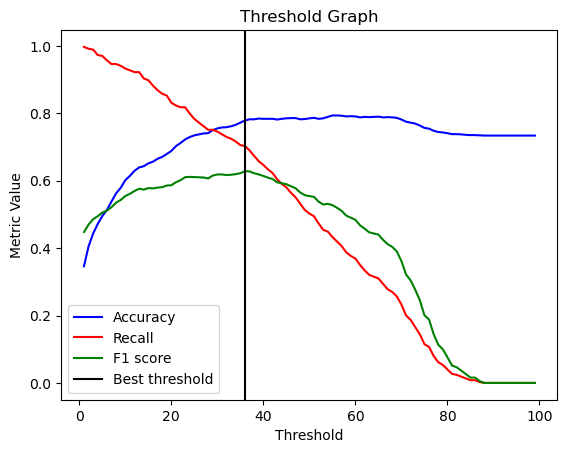

Confusion Matrix:
[[833 200]
 [111 263]]
Best Threshold: 0.36
Accuracy: 0.7789623312011372
Recall: 0.7032085561497327
F1: 0.6284348864994026


In [14]:
#Training 
model = LogisticRegression(max_iter=1000)
model.fit(xtrain, ytrain)

#Getting probabilities
yprob = model.predict_proba(xtest)
threshold = thresh(yprob[:, 1], ytest)
#threshold = 0.5
ypred = (yprob[:, 1] > threshold).astype(int)

# Use this
#Log results
evaluate(ytest,ypred, threshold)

In [15]:
# Use this
#Log results
evaluate(ytest,ypred, threshold)

Confusion Matrix:
[[833 200]
 [111 263]]
Best Threshold: 0.36
Accuracy: 0.7789623312011372
Recall: 0.7032085561497327
F1: 0.6284348864994026


# Oversample

In [16]:
fittedProb = model.predict_proba(xtrain)[:, 1]

In [17]:
fittedClass = (fittedProb > threshold).astype(int)
probdf = xtrain.copy()
probdf["Churn_Yes"] = ytrain
probdf["Prob"] = fittedProb
probdf["Class"] = fittedClass


In [18]:
evaluate(ytrain,fittedClass, threshold)

Confusion Matrix:
[[3374  756]
 [ 447 1048]]
Best Threshold: 0.36
Accuracy: 0.7861333333333334
Recall: 0.7010033444816054
F1: 0.6353440436495907


In [19]:
misses = probdf[probdf["Churn_Yes"] != probdf["Class"]]
len(misses)

1203

In [20]:
###Simple oversample###

class1 = probdf[probdf["Churn_Yes"] == 1]
distribution = dist(probdf)

oversample = class1.sample(n=(distribution[1]-distribution[0]), replace = True)

overDf = pd.concat([probdf, oversample], ignore_index=True)

dist(overDf)

Churn Yes: 1495
Churn No: 4130
Churn Yes: 4130
Churn No: 4130


(4130, 4130)

In [21]:
###Oversample misses###

missDf = pd.concat([probdf, misses], ignore_index=True)
len(missDf)


6828

In [22]:
probdf.head(5)

,tenure,MonthlyCharges,TotalCharges,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,...,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_Yes,Prob,Class
6030,43,49.05,2076.20,0,0,0,0,0,1,0,...,1,0,0,1,0,0,0,1,0.249405,0
3410,3,53.40,188.70,1,0,0,0,1,0,0,...,0,0,0,0,1,0,0,1,0.391491,1
5483,55,77.75,4458.15,0,0,1,0,1,0,1,...,0,0,0,1,0,1,0,1,0.271655,0
5524,45,54.65,2553.70,1,0,1,1,1,0,0,...,0,0,1,0,0,0,0,0,0.012312,0
6337,55,100.90,5448.60,0,0,1,1,1,0,1,...,1,1,0,0,0,0,1,0,0.122815,0


In [23]:
###Hybrid###

missedClass1 = misses[misses["Churn_Yes"] == 1]
overmiss = missedClass1.sample(n=(distribution[1]-distribution[0]), replace = True)

overMissDf = pd.concat([probdf, overmiss], ignore_index=True)
dist(overMissDf)


Churn Yes: 4130
Churn No: 4130


(4130, 4130)

# Similar Probability, Different Class

In [24]:
class1 = probdf[probdf["Churn_Yes"] == 1].sort_values(by="Prob")
class0 = probdf[probdf["Churn_Yes"] == 0].sort_values(by="Prob")

#Similar but different
SBD = pd.DataFrame()
notSBD = class0.copy()


with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    for i in range(len(class1)):
        #print(len(SBD))
        row = class1.iloc[i]
        SBD = SBD.append(row)
        row2 = findClosest(row["Prob"])
        SBD = SBD.append(row2)
    


In [25]:
print(len(notSBD))
print(len(class0))
print(len(probdf))
print(len(SBD))

2635
4130
5625
2990


In [26]:
SBD[["Churn_Yes", "Prob", "Class"]].head(5)

,Churn_Yes,Prob,Class
268,1.0,0.004228,0.0
4280,0.0,0.004217,0.0
4819,1.0,0.005233,0.0
3553,0.0,0.005233,0.0
4386,1.0,0.006440,0.0


# Hard/Easy To Predict

In [27]:
#Min and max prob
print("Min", max(float(class0["Prob"].head(1)), float(class1["Prob"].head(1))))
print("Max", min(float(class0["Prob"].tail(1)), float(class1["Prob"].tail(1))))
class1 = probdf[probdf["Churn_Yes"] == 1].sort_values(by="Prob")
class0 = probdf[probdf["Churn_Yes"] == 0].sort_values(by="Prob")

Min 0.004227954378193088
Max 0.8369896770916917


In [28]:
def hardToPredict(std, threshold):
    
    upperlimit = threshold + std
    lowerlimit = threshold - std
    
    print("Upperlimit:", upperlimit, "Lowerlimit:", lowerlimit)
    
    C0HP = class0[(class0["Prob"]>upperlimit)].sort_values(by="Prob", ascending = False)
    notC0Hp = class0[(class0["Prob"]<=upperlimit)]

    C1LP = class1[(class1["Prob"]<lowerlimit)].sort_values(by="Prob")
    notC1LP = class1[(class1["Prob"]>=lowerlimit)]
    
    with warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=FutureWarning)
        notHTP = pd.DataFrame().append(notC0Hp).append(notC1LP)
        HTP = pd.DataFrame()
        
        alternate = min(len(C0HP), len(C1LP))
        for i in range (0, alternate):
            HTP = HTP.append(C0HP.iloc[i]).append(C1LP.iloc[i])
            #print(len(orderedHTP))

        if (alternate == len(C0HP)):
            HTP = HTP.append(C1LP.iloc[(len(C0HP)):(len(C1LP))])

        else:
            HTP = HTP.append(C0HP.iloc[(len(C1LP)):(len(C0HP))])
    
    print("HTP:", len(HTP))
    print("notHTP:", len(notHTP))
    
    print("notHTP:", dist(HTP))
    print("notHTP:", dist(notHTP))
    
    return (HTP, notHTP)

In [29]:
stdProb = .5 * probdf["Prob"].std()

fullHTP = hardToPredict(stdProb, threshold)

notHTP = fullHTP[1]
HTP = fullHTP[0]

print("HTP:", len(HTP))
print("notHTP:", len(notHTP))

HTP[["Churn_Yes", "Prob", "Class"]].head(5)




Upperlimit: 0.48320046607665607 Lowerlimit: 0.2367995339233439
HTP: 706
notHTP: 4919
Churn Yes: 261
Churn No: 445
notHTP: (261, 445)
Churn Yes: 1234
Churn No: 3685
notHTP: (1234, 3685)
HTP: 706
notHTP: 4919


,Churn_Yes,Prob,Class
935,0.0,0.836990,1.0
268,1.0,0.004228,0.0
4150,0.0,0.826079,1.0
4819,1.0,0.005233,0.0
293,0.0,0.823613,1.0


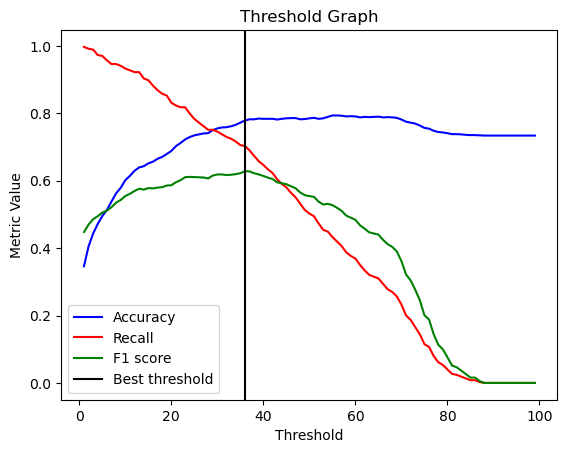

Confusion Matrix:
[[833 200]
 [111 263]]

True Positive: 263
True Negative: 833
False Positive: 200
False Negative: 111

Accuracy: 0.7789623312011372
True-Positve Rate: 0.7032085561497327
F1 score: 0.6284348864994026
Upperlimit: 0.481885625551434 Lowerlimit: 0.238114374448566
HTP: 203
notHTP: 1204
HTPTest: 203
notHTPTest: 1204


,Churn_Yes,Prob,Class
3159,0.0,0.867713,1.0
4795,1.0,0.008291,0.0
3346,0.0,0.840678,1.0
4513,1.0,0.016211,0.0
4618,0.0,0.826491,1.0


In [30]:
def hardToPredictTest(std, threshold):
    
    class0 = class0Test.copy()
    class1 = class1Test.copy()
    upperlimit = threshold + std
    lowerlimit = threshold - std
    
    print("Upperlimit:", upperlimit, "Lowerlimit:", lowerlimit)
    
    C0HP = class0[(class0["Prob"]>upperlimit)].sort_values(by="Prob", ascending = False)
    notC0Hp = class0[(class0["Prob"]<=upperlimit)]

    C1LP = class1[(class1["Prob"]<lowerlimit)].sort_values(by="Prob")
    notC1LP = class1[(class1["Prob"]>=lowerlimit)]
    
    with warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=FutureWarning)
        notHTP = pd.DataFrame().append(notC0Hp).append(notC1LP)
        HTP = pd.DataFrame()
        
        alternate = min(len(C0HP), len(C1LP))
        for i in range (0, alternate):
            HTP = HTP.append(C0HP.iloc[i]).append(C1LP.iloc[i])
            #print(len(orderedHTP))

        if (alternate == len(C0HP)):
            HTP = HTP.append(C1LP.iloc[(len(C0HP)):(len(C1LP))])

        else:
            HTP = HTP.append(C0HP.iloc[(len(C1LP)):(len(C0HP))])
    
    print("HTP:", len(HTP))
    print("notHTP:", len(notHTP))
    
    return (HTP, notHTP)

def evaluate(acc, pred):
    cm = confusion_matrix(acc, pred)
    print("Confusion Matrix:")
    print(cm)
    truePositive = cm[1, 1]
    trueNegative = cm[0, 0]
    falsePositive = cm[0, 1]
    falseNegative = cm[1, 0]
    print("\nTrue Positive:", truePositive)
    print("True Negative:", trueNegative)
    print("False Positive:", falsePositive)
    print("False Negative:", falseNegative)
    
    accuracy = accuracy_score(acc, pred)
    print("\nAccuracy:", accuracy)
    tpr = recall_score(acc, pred)
    print("True-Positve Rate:", tpr)
    f1 = f1_score(acc, pred)
    print("F1 score:", f1)
    
    return cm

#Training 
model = LogisticRegression(max_iter=1000)
model.fit(xtrain, ytrain)


#Getting probabilities
yprob = model.predict_proba(xtest)
thresholdTest = thresh(yprob[:, 1], ytest)
#threshold = 0.5
ypred = (yprob[:, 1] > thresholdTest).astype(int)
#Log results
evaluate(ytest,ypred)

test = xtest.copy()
test["Churn_Yes"] = ytest
test["Prob"] = yprob[:, 1]
test["Class"] = ypred

class1Test = test[test["Churn_Yes"] == 1].sort_values(by="Prob")
class0Test = test[test["Churn_Yes"] == 0].sort_values(by="Prob")

stdProbTest = .5 * test["Prob"].std()

fullHTPTest = hardToPredictTest(stdProbTest, thresholdTest)

notHTPTest = fullHTPTest[1]
HTPTest = fullHTPTest[0]

print("HTPTest:", len(HTPTest))
print("notHTPTest:", len(notHTPTest))

HTPTest[["Churn_Yes", "Prob", "Class"]].head(5)

In [31]:
upperlimit = threshold + stdProb
lowerlimit = threshold - stdProb

In [32]:
save = probdf[probdf['Prob'].between(lowerlimit, upperlimit)]

notsave = probdf.copy()
notsave = notsave.drop(save.index)

In [33]:
print(len(save))
print(len(notsave))
len(probdf)

1104
4521


5625

# Weighted Probability

In [34]:
import random
import math

In [35]:
def weightedBatches(higherWeightdf, lowerWeightdf, weightMultiplier, unitsPerBatch, v=False):
    numBatches = math.floor((len(higherWeightdf) + len(lowerWeightdf))/unitsPerBatch)
    
    high = higherWeightdf.copy()
    low = lowerWeightdf.copy()
    
    low["weight"] = 1
    high["weight"] = weightMultiplier
    
    joint = pd.concat([low, high])
    weighted = pd.DataFrame()
    
    numWeighted = []
    
    for i in range(numBatches):
        sample = joint.sample(n = unitsPerBatch, replace=False, weights='weight')
        joint = joint.drop(sample.index)
        
        numWeighted.append(len(sample[sample["weight"] == weightMultiplier]))
        weighted = pd.concat([weighted, sample])
    
    weighted = pd.concat([weighted, joint])
    
    mp = math.floor(len(numWeighted)/2)
    
    if (v):
        print("Weighted units per batch in first half:", sum(numWeighted[0:mp])/mp)

        print("Weighted units per batch in second half:", sum(numWeighted[mp:])/(len(numWeighted)-mp))
    
    return weighted.drop(["weight"], axis=1)


# Weighted Sample

In [36]:
def WNN(high, low, xtest, ytest):
    # Define the model architecture
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=30))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy',
                  metrics=['accuracy', f1_m])

    BCP.batch_accuracy.clear()
    BCP.batch_f1.clear()

    val_data = (xtest, ytest)

    accuracy = []
    val_accuracy = []
    f1 = []
    val_f1 = []
    epochs = range(1, 201)
    
    for i in range(200):
        df = weightedBatches(high, low, 5, 32)
        #print(df.head(1))
        xtrain = df.drop("Churn_Yes", axis=1)
        ytrain = df["Churn_Yes"]

        history = model.fit(xtrain, ytrain, epochs=1, batch_size=32, shuffle=False, 
                            validation_data=val_data, callbacks = [BCP()], verbose=0)
        accuracy.append(history.history['accuracy'])
        val_accuracy.append(history.history['val_accuracy'])
        f1.append(history.history['f1_m'])
        val_f1.append(history.history['val_f1_m'])
        
    ###########
    # Plot the accuracy values
    plt.plot(epochs, accuracy, 'b', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
    
    # Plot the recall values
    plt.plot(epochs, f1, 'k', label='Training f1')
    plt.plot(epochs, val_f1, 'c', label='Validation f1')

    plt.title('Training and Validation Metrics')
    plt.xlabel('Epochs')
    plt.ylabel('Metric Value')
    plt.legend()
    plt.show()
    ###########


    plt.plot(range(len(BCP.batch_f1)), BCP.batch_f1, 'r', label='F1')
    plt.title('Batch F1 Graph')
    plt.xlabel('Batch')
    plt.ylabel('F1')
    plt.legend()
    plt.show()

    print("########################   TRAIN   ########################")
    pred = model.predict(xtrain)
    threshold = thresh(pred, ytrain)
    evalNN(threshold, pred, ytrain)


    print("\n\n\n########################   TEST   ########################")
    pred = model.predict(xtest)
    evalNN(threshold, pred, ytest)

In [37]:
def perc(df, var):
    class0 = df[df["Churn_Yes"] == 0]
    class1 = df[df["Churn_Yes"] == 1]
    
    total = len(class0) + len(class1)
    zero = len(class0)/total
    one = len(class1)/total
    
    class0var0 = class0[class0[var] == 0]
    class0var1 = class0[class0[var] == 1]
    
    class1var0 = class1[class1[var] == 0]
    class1var1 = class1[class1[var] == 1]
    
    zeroZero = zero * len(class0var0)/len(class0)
    zeroOne = zero *len(class0var1)/len(class0)
    
    oneZero = one * len(class1var0)/len(class1)
    oneOne = one * len(class1var1)/len(class1)
    
    return([zeroZero, zeroOne, oneZero, oneOne])
    

In [38]:
def plotpie(df, var):
    labels = ["00", "01", "10", "11"]
    sizes = perc(df, var)
    print(sizes)
    colors = ['red', 'green', 'cyan', 'magenta']

    # Create the pie chart
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)

    # Set aspect ratio to be equal so that pie is drawn as a circle
    plt.axis('equal')

    # Add a title
    plt.title(var)

    # Display the chart
    plt.show()

# Decision Tree

In [39]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import plot_tree
from sklearn import tree

In [40]:
def varImp(t, df):
    varNames = df.columns.tolist()
    
    imp = t.feature_importances_
    impDict = {}
    
    for feature, importance in zip(varNames, imp):
        impDict[feature] = importance
    
    impDF = pd.DataFrame.from_dict(impDict, orient='index', columns=['Importance'])
    
    return impDF

    

In [41]:
def dtree(x, y, xtest, ytest):
    dtc = DecisionTreeClassifier()
    rfc = RandomForestClassifier(n_estimators=100, random_state=42)
    gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42, max_depth = 2)
    
    dtc.fit(x,y)
    rfc.fit(x,y)
    gbc.fit(x,y)
    
    print("--------------------Regular Tree--------------------")
    dtcimp = varImp(dtc, x)
    print(dtcimp.sort_values("Importance", ascending= False).head(5))
    yfit = dtc.predict(x)
    print("Training:")
    evaluate(y, yfit, .5)
    ypred = dtc.predict(xtest)
    print("Testomg:")
    evaluate(ytest, ypred, .5)
    
    
    print("--------------------Random Forest--------------------")
    rfcimp = varImp(rfc, x)
    print(rfcimp.sort_values("Importance", ascending= False).head(5))
    yfit = rfc.predict(x)
    ypred = rfc.predict(xtest)
    print("Training:")
    evaluate(y, yfit, .5)
    print("Testing:")
    evaluate(ytest, ypred, .5)
    
    print("--------------------Gradient Boost--------------------")
    gbcimp = varImp(gbc, x)
    print(gbcimp.sort_values("Importance", ascending= False).head(5))
    yfit = gbc.predict(x)
    ypred = gbc.predict(xtest)
    print("Training:")
    evaluate(y, yfit, .5)
    print("Testing:")
    evaluate(ytest, ypred, .5)
    
    
    
    
    

In [42]:
xColumns = list(probdf.columns)[:-3]


# Random Cluster

In [43]:
from sklearn_extra.cluster import KMedoids

In [44]:
def thresh(pred, ytest):
    bestf1 = 0
    bestthresh = 0
    #print(pred)
    for i in range(1,100):
        classPred = [0 if val < (i/100) else 1 for val in pred]
        f1 = f1_score(ytest, classPred)
        if (f1>bestf1):
            bestf1 = f1
            bestthresh=i
            
    return (bestthresh/100)

def NN(xtrain, ytrain, xtest, ytest, i=0):
    # Define the model architecture
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=30))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy',
                  metrics=['accuracy', recall_m, precision_m, f1_m])
    history = model.fit(xtrain, ytrain, epochs=200, batch_size=32, shuffle=True, verbose=0)
        
    fit = model.predict(xtrain)
    bestThresh = thresh(fit, ytrain)
    #bestThresh = .5
    fitPred = [0 if val < (bestThresh) else 1 for val in fit]
    print("Cluster", i, "Training")
    evaluate(ytrain, fitPred)
    print("Best Threshold:", bestThresh, "\n")
    
    
    test = model.predict(xtest)
    classPred = [0 if val < (bestThresh) else 1 for val in test]
    print("Cluster", i, "Testing")
    cm = evaluate(ytest, classPred)
    print("Best Threshold:", bestThresh, "\n")
    
    return(cm)
    
def evaluate(acc, pred):
    cm = confusion_matrix(acc, pred)
    print("Confusion Matrix:")
    print(cm)
    
    accuracy = accuracy_score(acc, pred)
    print("\nAccuracy:", accuracy)
    tpr = recall_score(acc, pred)
    print("True-Positve Rate:", tpr)
    f1 = f1_score(pred, acc)
    print("F1 score:", f1)
    
    return cm

def evaluateCM(cm):
    print('\033[1m', "\nTotal Confusion Matrix:", '\033[0m')
    print(cm)
    tp = cm[1, 1]
    tn = cm[0, 0]
    fp = cm[0, 1]
    fn = cm[1, 0]
    
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    
    # Calculate precision and recall
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    # Calculate F1 score
    f1 = 2 * (precision * recall) / (precision + recall)

    print("\nAccuracy:", accuracy)
    print("True-Positve Rate:", recall)
    print("F1 score:", f1)
    
    return (f1)

def randomCluster(train, test, n):
    xtrain = train[xColumns]
    ytrain = train["Churn_Yes"]
    
    xtest = test[xColumns]
    ytest = test["Churn_Yes"]
    
    kmedoids = KMedoids(n_clusters=n)
    
    kmedoids.fit(xtrain)
    
    train["Cluster"] = kmedoids.labels_
    
    test["Cluster"] = kmedoids.predict(xtest)
    
    cmList = []
    
    for i in range(n):
        print('\033[1m', "Cluster:", i+1, '\033[0m')
        ctrain = train[train["Cluster"] == i]
        ctest = test[test["Cluster"] == i]
        
        cxtrain = ctrain[xColumns]
        cytrain = ctrain["Churn_Yes"]
        
        cxtest = ctest[xColumns]
        cytest = ctest["Churn_Yes"]
        
        cm = NN(cxtrain, cytrain, cxtest, cytest, i+1)
        cmList.append(cm)
    
    totalCM = sum(cmList)
    evaluateCM(totalCM)
    
def fixedCluster(train, train2, test, n):
    xtrain = train[xColumns]
    ytrain = train["Churn_Yes"]
    
    xtrain2 = train2[xColumns]
    ytrain2 = train2["Churn_Yes"]
    
    xtest = test[xColumns]
    ytest = test["Churn_Yes"]
    
    kmedoids = KNeighborsClassifier(n_neighbors=3)
    
    kmedoids.fit(xtrain, )
    
    train["Cluster"] = kmedoids.labels_
    
    test["Cluster"] = kmedoids.predict(xtest)
    
    cmList = []
    
    for i in range(n):
        print('\033[1m', "Cluster:", i+1, '\033[0m')
        ctrain = train[train["Cluster"] == i]
        ctest = test[test["Cluster"] == i]
        
        cxtrain = ctrain[xColumns]
        cytrain = ctrain["Churn_Yes"]
        
        cxtest = ctest[xColumns]
        cytest = ctest["Churn_Yes"]
        
        cm = NN(cxtrain, cytrain, cxtest, cytest, i+1)
        cmList.append(cm)
    
    totalCM = sum(cmList)
    evaluateCM(totalCM)

In [45]:
#randomCluster(probdf, test, 5)

# Different Probability

In [46]:
def NN(totalTrain, xtrain, ytrain, xtest, ytest):
    # Define the model architecture
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=30))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy',
                  metrics=['accuracy', recall_m, precision_m, f1_m])
    history = model.fit(xtrain, ytrain, epochs=200, batch_size=32, shuffle=True, verbose=0)
        
    fit = model.predict(xtrain)
    bestThresh = thresh(fit, ytrain)
    fitPred = [0 if val < (bestThresh) else 1 for val in fit]
    evaluate(ytrain, fitPred)
    print("Best Threshold:", bestThresh, "\n")
    
    
    test = model.predict(xtest)
    classPred = [0 if val < (bestThresh) else 1 for val in test]
    cm = evaluate(ytest, classPred)
    print("Best Threshold:", bestThresh, "\n")
    
    totalfit = model.predict(totalTrain[xColumns])
    
    return([totalfit, test])

def DP(totalTrain, train, train2, test):
    xtrain = train[xColumns]
    ytrain = train["Churn_Yes"]
    
    xtrain2 = train2[xColumns]
    ytrain2 = train2["Churn_Yes"]
    
    xtest = test[xColumns]
    ytest = test["Churn_Yes"]
    
    predictionsHTP = NN(totalTrain, xtrain, ytrain, xtest, ytest)
    predictionsNormal = NN(totalTrain, xtrain2, ytrain2, xtest, ytest)
    
    #predictions from both HTP and Normal on entire train and test set
    return([predictionsHTP, predictionsNormal])
    
    
def DP2(totalTrain, test, pred):
    xtest = test[xColumns]
    ytest = test["Churn_Yes"]

    #Add predictions to test and train dfs
    TT = totalTrain.copy()
    TT['HTP'] = pred[0][0]
    TT['Normal'] = pred[1][0]
    
    DPTest = test.copy()
    DPTest['HTP'] = pred[0][1]
    DPTest['Normal'] = pred[1][1]
    
    #Set DP dfs
    trainForDP = TT[abs(TT['HTP'] - TT['Normal']) > .60].copy()
    trainForDP["DP"] = "Yes"
    notDPTrain = TT[abs(TT['HTP'] - TT['Normal']) <= .60].copy()
    notDPTrain["DP"] = "No"
    print("DP units in training set:", len(trainForDP))
    
    xtrainForDP = trainForDP[xColumns]
    ytrainForDP = trainForDP["Churn_Yes"]
    
    testForDP = DPTest[abs(DPTest['HTP'] - DPTest['Normal']) > .60].copy()
    testForDP["DP"] = "Yes"
    notDPTest = DPTest[abs(DPTest['HTP'] - DPTest['Normal']) <= .60].copy()
    notDPTest["DP"] = "No"
    print("DP units in test set:", len(testForDP))

    DPpred = NN(totalTrain, xtrainForDP, ytrainForDP, xtest, ytest)
    
    tt = pd.concat([trainForDP, notDPTrain])
    dpTest = pd.concat([testForDP, notDPTest])
    
    #Add DP predictions to test df
    tt["DPpred"] = DPpred[0]
    dpTest['DPpred'] = DPpred[1]
    
    #Return train and test set with following added columns, prediction from HTP, prediction from notHTP, prediction from DP,
    #and whether or not the sample unit is DP
    return (tt, dpTest)
    

In [47]:
#r1 = DP(probdf, HTP, notHTP, test)

In [48]:
#r2 = DP2(probdf, test, r1)

In [49]:
"""tset = r2[1].copy()
DPset = tset[tset["DP"] == "Yes"]
notDPset = tset[tset["DP"] == "No"]
classPred = [0 if val < 0.38 else 1 for val in DPset["DPpred"]]

combine =  [max(x, y, key=lambda num: abs(num - 50)) for x, y in zip(notDPset["Normal"], notDPset["HTP"])]

classPred2 = [0 if val < 0.32  else 1 for val in combine]

dpcm = evaluate(DPset["Churn_Yes"], classPred)
acm = evaluate(notDPset["Churn_Yes"], classPred2)

evaluateCM(dpcm+acm)"""


'tset = r2[1].copy()\nDPset = tset[tset["DP"] == "Yes"]\nnotDPset = tset[tset["DP"] == "No"]\nclassPred = [0 if val < 0.38 else 1 for val in DPset["DPpred"]]\n\ncombine =  [max(x, y, key=lambda num: abs(num - 50)) for x, y in zip(notDPset["Normal"], notDPset["HTP"])]\n\nclassPred2 = [0 if val < 0.32  else 1 for val in combine]\n\ndpcm = evaluate(DPset["Churn_Yes"], classPred)\nacm = evaluate(notDPset["Churn_Yes"], classPred2)\n\nevaluateCM(dpcm+acm)'

In [50]:
    
def hardToPredictTest(std, threshold):
    
    class0 = class0Test.copy()
    class1 = class1Test.copy()
    upperlimit = threshold + std
    lowerlimit = threshold - std
    
    print("Upperlimit:", upperlimit, "Lowerlimit:", lowerlimit)
    
    C0HP = class0[(class0["Prob"]>upperlimit)].sort_values(by="Prob", ascending = False)
    notC0Hp = class0[(class0["Prob"]<=upperlimit)]

    C1LP = class1[(class1["Prob"]<lowerlimit)].sort_values(by="Prob")
    notC1LP = class1[(class1["Prob"]>=lowerlimit)]
    
    with warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=FutureWarning)
        notHTP = pd.DataFrame().append(notC0Hp).append(notC1LP)
        HTP = pd.DataFrame()
        
        alternate = min(len(C0HP), len(C1LP))
        for i in range (0, alternate):
            HTP = HTP.append(C0HP.iloc[i]).append(C1LP.iloc[i])
            #print(len(orderedHTP))

        if (alternate == len(C0HP)):
            HTP = HTP.append(C1LP.iloc[(len(C0HP)):(len(C1LP))])

        else:
            HTP = HTP.append(C0HP.iloc[(len(C1LP)):(len(C0HP))])
    
    print("Upperlimit:", (upperlimit))
    print("Lowerlimit:", (lowerlimit))
    
    return (HTP, notHTP)

def NN(df, xtest, ytest, t2=False, bo = False):
    # Define the model architecture
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=30))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy',
                  metrics=['accuracy', recall_m, precision_m, f1_m])

    
    xtrain = df.drop("Churn_Yes", axis=1)
    ytrain = df["Churn_Yes"]
    
    print("Starting Model Training")
    history = model.fit(xtrain, ytrain, epochs=200, batch_size=32, shuffle=True, verbose=0)
    print("Model Training Finished")
    
    if (bo):
        yprob = model.predict(t2.drop(["Class", "Prob", "Churn_Yes"], axis = 1))
        print("NN", yprob[0], "acutal", t2["Churn_Yes"].head(1))
        # Create a scatter plot
        plt.scatter(yprob, t2.index, c=t2["Churn_Yes"], cmap='viridis')
        plt.xlabel('Predicted Probability')
        plt.ylabel('Sample Unit')
        plt.title('Predicted Probabilities and Class Labels')
        plt.show()
        
    print("Training ROC:")
    pred = model.predict(xtrain)
    
    #print(pred)
    plotROC(pred, ytrain)
    #plotNN(history)
    return(evalNN(model, xtest, ytest))

def evalNN(model, xtest, ytest):
    pred = model.predict(xtest)
    # Plot the histogram
    print("Test ROC:")
    plotROC(pred, ytest)
    bestThresh = thresh(pred, ytest)
    classPred = [0 if val < bestThresh else 1 for val in pred]
    return(evaluate(ytest, classPred))

def NN2(df, df2, test, test2):
    
    df = df.drop(["Class", "Prob"], axis =1)
    len(df)
    xt = test.drop(["Class", "Prob", "Churn_Yes"], axis=1)
    len(xt)
    yt = test["Churn_Yes"]
    len(yt)

    NN1CM = NN(df, xt, yt)
    
    df2 = df2.drop(["Class", "Prob"], axis =1)
    len(df2)
    xt2 = test2.drop(["Class", "Prob", "Churn_Yes"], axis=1)
    len(xt)
    yt2 = test2["Churn_Yes"]
    len(yt)
    
    NN2CM = NN(df2, xt2, yt2)
    
    return (evaluateCM(NN1CM+NN2CM))

def NNTree(df, df2, test, test2):
    
    df = df.drop(["Class", "Prob"], axis =1)
    xt = test.drop(["Class", "Prob", "Churn_Yes"], axis=1)
    yt = test["Churn_Yes"]

    gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42, max_depth = 2)
    gbc.fit(df.drop(["Churn_Yes"], axis=1),df["Churn_Yes"])
    ypred = gbc.predict(xt)
    NN1CM = evaluate(yt, ypred)
    
    df2 = df2.drop(["Class", "Prob"], axis =1)
    len(df2)
    xt2 = test2.drop(["Class", "Prob", "Churn_Yes"], axis=1)
    len(xt)
    yt2 = test2["Churn_Yes"]
    len(yt)
    
    predict = pd.concat([test, test2])
    yprob = gbc.predict_proba(predict.drop(["Churn_Yes", "Class", "Prob"], axis = 1))
    print("tree", yprob[:, 1][0], "acutal", predict["Churn_Yes"].head(1))
    # Create a scatter plot
    plt.scatter(yprob[:, 1], predict.index, c=predict["Churn_Yes"], cmap='viridis')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Sample Unit')
    plt.title('Predicted Probabilities and Class Labels')
    plt.show()
    
    NN2CM = NN(df2, xt2, yt2, predict, True)
    
    return (evaluateCM(NN1CM+NN2CM))

    
#Training 
model = LogisticRegression(max_iter=1000)
model.fit(xtrain, ytrain)


#Getting probabilities
yprob = model.predict_proba(xtest)
thresholdTest = thresh(yprob[:, 1], ytest)
#threshold = 0.5
ypred = (yprob[:, 1] > thresholdTest).astype(int)
#Log results
evaluate(ytest,ypred)


test = xtest.copy()
test["Churn_Yes"] = ytest
test["Prob"] = yprob[:, 1]
test["Class"] = ypred

stdProbTest = .5 * test["Prob"].std()

fullHTPTest = hardToPredictTest(stdProbTest, thresholdTest)

notHTPTest = fullHTPTest[1]
HTPTest = fullHTPTest[0]

print("HTPTest:", len(HTPTest))
print("notHTPTest:", len(notHTPTest))

HTPTest[["Churn_Yes", "Prob", "Class"]].head(5)

HTPTest["HTP"] = 1
notHTPTest["HTP"] = 0

TestHTP = pd.concat([HTPTest, notHTPTest])

Confusion Matrix:
[[833 200]
 [111 263]]

Accuracy: 0.7789623312011372
True-Positve Rate: 0.7032085561497327
F1 score: 0.6284348864994026
Upperlimit: 0.481885625551434 Lowerlimit: 0.238114374448566
Upperlimit: 0.481885625551434
Lowerlimit: 0.238114374448566
HTPTest: 203
notHTPTest: 1204


# Threshold


In [51]:
def MakeNN(xtrain, ytrain, xtest, ytest):
    # Define the model architecture
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=30))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy',
                  metrics=['accuracy', recall_m, precision_m, f1_m])
    
    history = model.fit(xtrain, ytrain, epochs=200, batch_size=32, shuffle=True, verbose=0)
    fit = model.predict(xtrain)
    bestThresh = thresh(fit, ytrain)
    
    prob = model.predict(xtest)
    pred = [0 if val <bestThresh else 1 for val in prob]
    
    evaluate(ytest, pred)
    
    return(model, bestThresh, pred)

def MakeLog(xtrain, ytrain, xtest, ytest):
    model = LogisticRegression(max_iter=10000)
    model.fit(xtrain, ytrain)
    fit = model.predict_proba(xtrain)[:, 1]
    bestThresh = thresh(fit, ytrain)
    print("BestThresh:", bestThresh)
    
    prob = model.predict_proba(xtest)[:, 1]
    pred = [0 if val <bestThresh else 1 for val in prob]
    
    evaluate(ytest, pred)
    
    return(model)

def MakeCluster(xtrain, n):
    kmedoids = KMedoids(n_clusters=n)
    kmedoids.fit(xtrain)
    
    return(kmedoids)

def MakeTree(xtrain, ytrain, xtest, ytest):
    gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42, max_depth = 2)
    gbc.fit(xtrain, ytrain)
    
    pred = gbc.predict(xtest)
    evaluate(ytest, pred)
    
    return(gbc)

def HTPModel(test, HTPModel, notHTPModel):
    
    HT = test[test["HTP"] == 1]
    print("Number of HTP units:", len(HT))
    NHT = test[test["HTP"] == 0]
    print("Numbrt of notHTP units", len(NHT))

    HTPPred = HTPModel.predict(HT[xColumns])
    
    notHTPProb = notHTPModel[0].predict(NHT[xColumns])
    notHTPPred = [0 if val < notHTPModel[1]  else 1 for val in notHTPProb]
    
    print("HTP Tree Performance:")
    HTPCM = evaluate(HT["Churn_Yes"], HTPPred)

    
    print("notHTP NN Performance:")
    notHTPCM = evaluate(NHT["Churn_Yes"], notHTPPred)
    
    return(evaluateCM(HTPCM+notHTPCM))
    


In [52]:
"""HTPTree = MakeTree(HTP[xColumns], HTP["Churn_Yes"], HTPTest[xColumns], HTPTest["Churn_Yes"])"""

'HTPTree = MakeTree(HTP[xColumns], HTP["Churn_Yes"], HTPTest[xColumns], HTPTest["Churn_Yes"])'

In [53]:
"""simpleHTP = MakeLog(HTP[xColumns], HTP["Churn_Yes"], HTPTest[xColumns], HTPTest["Churn_Yes"])"""

'simpleHTP = MakeLog(HTP[xColumns], HTP["Churn_Yes"], HTPTest[xColumns], HTPTest["Churn_Yes"])'

In [54]:
"""notHTPNN = MakeNN(notHTP[xColumns], notHTP["Churn_Yes"], notHTPTest[xColumns], notHTPTest["Churn_Yes"])"""

'notHTPNN = MakeNN(notHTP[xColumns], notHTP["Churn_Yes"], notHTPTest[xColumns], notHTPTest["Churn_Yes"])'

In [55]:
"""simpleNotHTP = MakeLog(notHTP[xColumns], notHTP["Churn_Yes"], notHTPTest[xColumns], notHTPTest["Churn_Yes"])"""

'simpleNotHTP = MakeLog(notHTP[xColumns], notHTP["Churn_Yes"], notHTPTest[xColumns], notHTPTest["Churn_Yes"])'

In [56]:
HTP["HTP"] = 1
notHTP["HTP"] = 0
DF_HTP = pd.concat([notHTP, HTP])


In [57]:
"""HTPLog = MakeLog(DF_HTP[xColumns], DF_HTP["HTP"], TestHTP[xColumns], TestHTP["HTP"])

probHTP = HTPLog.predict_proba(test[xColumns])

HTPThreshold = .5





predHTP = [0 if val < HTPThreshold  else 1 for val in probHTP[:, 1]]

test["HTP"] = predHTP

"""


'HTPLog = MakeLog(DF_HTP[xColumns], DF_HTP["HTP"], TestHTP[xColumns], TestHTP["HTP"])\n\nprobHTP = HTPLog.predict_proba(test[xColumns])\n\nHTPThreshold = .5\n\n\n\n\n\npredHTP = [0 if val < HTPThreshold  else 1 for val in probHTP[:, 1]]\n\ntest["HTP"] = predHTP\n\n'

In [58]:
"""HTPModel(test, HTPTree, notHTPNN)"""

'HTPModel(test, HTPTree, notHTPNN)'

In [59]:
"""numHTP = []
numNotHTP = []
threshList = []
f1List = []
f1ThreshList = []

for i in range(1, 101):
    threshList.append(i)
    HTPThreshold = i/100
    predHTP = [0 if val < HTPThreshold  else 1 for val in probHTP[:, 1]]
    numHTP.append(predHTP.count(1))
    numNotHTP.append(predHTP.count(0))
    
    if ((predHTP.count(1)>0) and (predHTP.count(0)>0)):
        test["HTP"] = predHTP
        f1List.append(HTPModel(test, HTPTree, notHTPNN))
        f1ThreshList.append(i)"""

'numHTP = []\nnumNotHTP = []\nthreshList = []\nf1List = []\nf1ThreshList = []\n\nfor i in range(1, 101):\n    threshList.append(i)\n    HTPThreshold = i/100\n    predHTP = [0 if val < HTPThreshold  else 1 for val in probHTP[:, 1]]\n    numHTP.append(predHTP.count(1))\n    numNotHTP.append(predHTP.count(0))\n    \n    if ((predHTP.count(1)>0) and (predHTP.count(0)>0)):\n        test["HTP"] = predHTP\n        f1List.append(HTPModel(test, HTPTree, notHTPNN))\n        f1ThreshList.append(i)'

In [60]:
"""plt.plot(threshList, numHTP, 'b', label='HTP')
plt.plot(threshList, numNotHTP, 'r', label='notHTP')
plt.axvline(x = 18, color = 'k', label = 'Best threshold')
plt.title('Threshold Graph')
plt.xlabel('Threshold')
plt.ylabel('Count')
plt.legend()
plt.show()"""

"plt.plot(threshList, numHTP, 'b', label='HTP')\nplt.plot(threshList, numNotHTP, 'r', label='notHTP')\nplt.axvline(x = 18, color = 'k', label = 'Best threshold')\nplt.title('Threshold Graph')\nplt.xlabel('Threshold')\nplt.ylabel('Count')\nplt.legend()\nplt.show()"

In [61]:
"""plt.plot(f1ThreshList, f1List, 'r', label='f1')
plt.axvline(x = 18, color = 'k', label = 'Best threshold')
plt.title('F1 Graph')
plt.xlabel('Threshold')
plt.ylabel('f1')
plt.legend()
plt.show()"""

"plt.plot(f1ThreshList, f1List, 'r', label='f1')\nplt.axvline(x = 18, color = 'k', label = 'Best threshold')\nplt.title('F1 Graph')\nplt.xlabel('Threshold')\nplt.ylabel('f1')\nplt.legend()\nplt.show()"

# Cluster Threshold

In [62]:
def cluster(df, test):
    xtrain1 = df[xColumns]
    ytrain1 = df["Churn_Yes"]
    
    xtest = test[xColumns]
    ytest = test["Churn_Yes"]
    
    k1 = KMedoids(n_clusters=1)
    k1.fit(xtrain1)
    
    
    print(k1.inertia_/len(xtrain1))
    
    d1 = k1.transform(xtest)
    
    print(min(d1), max(d1))
    
    bestf1 = 0
    f1list = []
    bestThreshold = 0
    thresholdlist = []
    bestcm = None
    
    
    for i in range(10,7740):
        predHTP = [1 if val < i  else 0 for val in d1]
        f1 = f1_score(test["HTP"], predHTP)
        f1list.append(f1)
        thresholdlist.append(i)
        if(f1 > bestf1):
            bestf1 = f1
            bestThreshold = i
            cm = confusion_matrix(test["HTP"], predHTP)
            bestcm = cm
            
    return ([bestf1, f1list, bestThreshold, thresholdlist, bestcm])
        

In [63]:
"""HTPTest["HTP"] = 1
notHTPTest["HTP"] = 0
DF_HTP_Test = pd.concat([HTPTest, notHTPTest]) """

'HTPTest["HTP"] = 1\nnotHTPTest["HTP"] = 0\nDF_HTP_Test = pd.concat([HTPTest, notHTPTest]) '

In [64]:
"""dat = cluster(HTP, DF_HTP_Test)"""

'dat = cluster(HTP, DF_HTP_Test)'

In [65]:
"""plt.plot(dat[3], dat[1], 'r', label='f1')
plt.axvline(x = dat[2], color = 'k', label = 'Best threshold')
plt.title('F1 HTP Graph')
plt.xlabel('Threshold')
plt.ylabel('f1')
plt.legend()
plt.show()"""

"plt.plot(dat[3], dat[1], 'r', label='f1')\nplt.axvline(x = dat[2], color = 'k', label = 'Best threshold')\nplt.title('F1 HTP Graph')\nplt.xlabel('Threshold')\nplt.ylabel('f1')\nplt.legend()\nplt.show()"

In [66]:
"""dat[4]"""

'dat[4]'

# NotHTP vs Normal

In [67]:
"""notHTPModel = MakeNN(notHTP[xColumns], notHTP["Churn_Yes"], test[xColumns], test["Churn_Yes"])"""

'notHTPModel = MakeNN(notHTP[xColumns], notHTP["Churn_Yes"], test[xColumns], test["Churn_Yes"])'

In [68]:
"""HTPModel = MakeNN(probdf[xColumns], probdf["Churn_Yes"], test[xColumns], test["Churn_Yes"])"""

'HTPModel = MakeNN(probdf[xColumns], probdf["Churn_Yes"], test[xColumns], test["Churn_Yes"])'

# KNN


In [69]:
from sklearn.neighbors import KNeighborsClassifier\

HTPTest["HTP"] = 1
notHTPTest["HTP"] = 0

DF_HTP_Test = pd.concat([HTPTest, notHTPTest])

kmedoids = KNeighborsClassifier()

kmedoids.fit(DF_HTP[xColumns], DF_HTP["HTP"])

preds = kmedoids.predict(test[xColumns])

evaluate(DF_HTP_Test["HTP"], preds)


Confusion Matrix:
[[1165   39]
 [ 194    9]]

Accuracy: 0.8343994314143568
True-Positve Rate: 0.04433497536945813
F1 score: 0.07171314741035857


array([[1165,   39],
       [ 194,    9]], dtype=int64)

# More pie charts

In [70]:
def dtree(x, y, xtest, ytest):
    dtc = DecisionTreeClassifier()
    rfc = RandomForestClassifier(n_estimators=100, random_state=42)
    gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42, max_depth = 2)
    
    dtc.fit(x,y)
    rfc.fit(x,y)
    gbc.fit(x,y)
    
    print("--------------------Regular Tree--------------------")
    dtcimp = varImp(dtc, x)
    print(dtcimp.sort_values("Importance", ascending= False).head(5))
    yfit = dtc.predict(x)
    print("Training:")
    evaluate(y, yfit)
    ypred = dtc.predict(xtest)
    print("Testomg:")
    evaluate(ytest, ypred)
    
    
    print("--------------------Random Forest--------------------")
    rfcimp = varImp(rfc, x)
    print(rfcimp.sort_values("Importance", ascending= False).head(5))
    yfit = rfc.predict(x)
    ypred = rfc.predict(xtest)
    print("Training:")
    evaluate(y, yfit)
    print("Testing:")
    evaluate(ytest, ypred)
    
    print("--------------------Gradient Boost--------------------")
    gbcimp = varImp(gbc, x)
    print(gbcimp.sort_values("Importance", ascending= False).head(5))
    yfit = gbc.predict(x)
    ypred = gbc.predict(xtest)
    print("Training:")
    evaluate(y, yfit)
    print("Testing:")
    evaluate(ytest, ypred)

In [71]:
#dtree(DF_HTP_Test[xColumns], DF_HTP_Test["Churn_Yes"], DF_HTP[xColumns], DF_HTP["Churn_Yes"])

In [72]:
# Histograms of numerical Variables

"""# Create the histogram with two bars per bin
plt.hist([HTP["tenure"], notHTP["tenure"]], label=['HTP', 'notHTP'])

# Add labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of tenure')
plt.legend()

# Show the plot
plt.show()


# Create the histogram with two bars per bin
plt.hist([HTP["TotalCharges"], notHTP["TotalCharges"]], label=['HTP', 'notHTP'])

# Add labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of TotalCharges')
plt.legend()

# Show the plot
plt.show()


# Create the histogram with two bars per bin
plt.hist([HTP["MonthlyCharges"], notHTP["MonthlyCharges"]], label=['HTP', 'notHTP'])

# Add labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of MonthlyCharges')
plt.legend()

# Show the plot
plt.show()"""

'# Create the histogram with two bars per bin\nplt.hist([HTP["tenure"], notHTP["tenure"]], label=[\'HTP\', \'notHTP\'])\n\n# Add labels and title\nplt.xlabel(\'Values\')\nplt.ylabel(\'Frequency\')\nplt.title(\'Histogram of tenure\')\nplt.legend()\n\n# Show the plot\nplt.show()\n\n\n# Create the histogram with two bars per bin\nplt.hist([HTP["TotalCharges"], notHTP["TotalCharges"]], label=[\'HTP\', \'notHTP\'])\n\n# Add labels and title\nplt.xlabel(\'Values\')\nplt.ylabel(\'Frequency\')\nplt.title(\'Histogram of TotalCharges\')\nplt.legend()\n\n# Show the plot\nplt.show()\n\n\n# Create the histogram with two bars per bin\nplt.hist([HTP["MonthlyCharges"], notHTP["MonthlyCharges"]], label=[\'HTP\', \'notHTP\'])\n\n# Add labels and title\nplt.xlabel(\'Values\')\nplt.ylabel(\'Frequency\')\nplt.title(\'Histogram of MonthlyCharges\')\nplt.legend()\n\n# Show the plot\nplt.show()'

In [73]:
# Pie Chart of categorical Variables

In [74]:
def perc(df, var):
    class0 = df[df["HTP"] == 0]
    class1 = df[df["HTP"] == 1]
    
    total = len(class0) + len(class1)
    zero = len(class0)/total
    one = len(class1)/total
    
    class0var0 = class0[class0[var] == 0]
    class0var1 = class0[class0[var] == 1]
    
    class1var0 = class1[class1[var] == 0]
    class1var1 = class1[class1[var] == 1]
    
    zeroZero = zero * len(class0var0)/len(class0)
    zeroOne = zero *len(class0var1)/len(class0)
    
    oneZero = one * len(class1var0)/len(class1)
    oneOne = one * len(class1var1)/len(class1)
    
    return([zeroZero, zeroOne, oneZero, oneOne])

def plotpie(df, var):
    labels = ["HTP0Var0", "HTP0Var1", "HTP1Var0", "HTP1Var1"]
    sizes = perc(df, var)
    print(sizes)
    colors = ['red', 'green', 'cyan', 'magenta']

    # Create the pie chart
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)

    # Set aspect ratio to be equal so that pie is drawn as a circle
    plt.axis('equal')

    # Add a title
    plt.title(var)

    # Display the chart
    plt.show()

In [75]:
"""for column in xColumns[3:]:
    print(column)
    #plotpie(DF_HTP, column)"""

'for column in xColumns[3:]:\n    print(column)\n    #plotpie(DF_HTP, column)'

In [76]:
"""for column in xColumns[3:]:
    #plotpie(DF_HTP_Test, column)"""

'for column in xColumns[3:]:\n    #plotpie(DF_HTP_Test, column)'

In [77]:
DF_HTP['predHTP'] = 1

DF_HTP.loc[DF_HTP['PhoneService_Yes'] == 0, 'predHTP'] = 0
DF_HTP.loc[DF_HTP['MultipleLines_No phone service'] == 1, 'predHTP'] = 0
DF_HTP.loc[DF_HTP['InternetService_No'] == 1, 'predHTP'] = 0
DF_HTP.loc[DF_HTP['OnlineSecurity_No internet service'] == 1, 'predHTP'] = 0
DF_HTP.loc[DF_HTP['OnlineBackup_No internet service'] == 1, 'predHTP'] = 0
DF_HTP.loc[DF_HTP['DeviceProtection_No internet service'] == 1, 'predHTP'] = 0
DF_HTP.loc[DF_HTP['TechSupport_No internet service'] == 1, 'predHTP'] = 0
DF_HTP.loc[DF_HTP['StreamingTV_No internet service'] == 1, 'predHTP'] = 0
DF_HTP.loc[DF_HTP['StreamingMovies_No internet service'] == 1, 'predHTP'] = 0
DF_HTP.loc[DF_HTP['Contract_One year'] == 1, 'predHTP'] = 0
DF_HTP.loc[DF_HTP['Contract_Two year'] == 1, 'predHTP'] = 0

print(len(DF_HTP[DF_HTP['predHTP'] == 1]))
print(len(DF_HTP[DF_HTP['predHTP'] == 0]))

evaluate(DF_HTP['HTP'], DF_HTP['predHTP'])


2358
3267
Confusion Matrix:
[[3022 1897]
 [ 245  461]]

Accuracy: 0.6192
True-Positve Rate: 0.6529745042492918
F1 score: 0.3009138381201044


array([[3022, 1897],
       [ 245,  461]], dtype=int64)

In [78]:
DF_HTP_Test['predHTP'] = 1

DF_HTP_Test.loc[DF_HTP_Test['PhoneService_Yes'] == 0, 'predHTP'] = 0
DF_HTP_Test.loc[DF_HTP_Test['MultipleLines_No phone service'] == 1, 'predHTP'] = 0
DF_HTP_Test.loc[DF_HTP_Test['InternetService_No'] == 1, 'predHTP'] = 0
DF_HTP_Test.loc[DF_HTP_Test['OnlineSecurity_No internet service'] == 1, 'predHTP'] = 0
DF_HTP_Test.loc[DF_HTP_Test['OnlineBackup_No internet service'] == 1, 'predHTP'] = 0
DF_HTP_Test.loc[DF_HTP_Test['DeviceProtection_No internet service'] == 1, 'predHTP'] = 0
DF_HTP_Test.loc[DF_HTP_Test['TechSupport_No internet service'] == 1, 'predHTP'] = 0
DF_HTP_Test.loc[DF_HTP_Test['StreamingTV_No internet service'] == 1, 'predHTP'] = 0
DF_HTP_Test.loc[DF_HTP_Test['StreamingMovies_No internet service'] == 1, 'predHTP'] = 0
DF_HTP_Test.loc[DF_HTP_Test['Contract_One year'] == 1, 'predHTP'] = 0
DF_HTP_Test.loc[DF_HTP_Test['Contract_Two year'] == 1, 'predHTP'] = 0

print(len(DF_HTP_Test[DF_HTP_Test['predHTP'] == 1]))
print(len(DF_HTP_Test[DF_HTP_Test['predHTP'] == 0]))

evaluate(DF_HTP_Test['HTP'], DF_HTP_Test['predHTP'])

617
790
Confusion Matrix:
[[720 484]
 [ 70 133]]

Accuracy: 0.6062544420753376
True-Positve Rate: 0.6551724137931034
F1 score: 0.32439024390243903


array([[720, 484],
       [ 70, 133]], dtype=int64)

In [79]:
#results = MakeNN(DF_HTP[xColumns], DF_HTP['HTP'], DF_HTP_Test[xColumns], DF_HTP_Test['HTP'])

In [80]:
def NN(xtrain, ytrain, xtest, ytest):
    # Define the model architecture
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=30))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy',
                  metrics=['accuracy', recall_m, precision_m, f1_m])

    
    print("Starting Model Training")
    history = model.fit(xtrain, ytrain, epochs=200, batch_size=32, shuffle=True, verbose=0)
    print("Model Training Finished")
        
    print("Training ROC:")
    pred = model.predict(xtrain)
    
    #print(pred)
    plotROC(pred, ytrain)
    #plotNN(history)
    return(evalNN(model, xtest, ytest))

def evaluate(acc, pred):
    cm = confusion_matrix(acc, pred)
    print("Confusion Matrix:")
    print(cm)
    truePositive = cm[1, 1]
    trueNegative = cm[0, 0]
    falsePositive = cm[0, 1]
    falseNegative = cm[1, 0]
    print("\nTrue Positive:", truePositive)
    print("True Negative:", trueNegative)
    print("False Positive:", falsePositive)
    print("False Negative:", falseNegative)
    
    accuracy = accuracy_score(acc, pred)
    print("\nAccuracy:", accuracy)
    tpr = recall_score(acc, pred)
    print("True-Positve Rate:", tpr)
    f1 = f1_score(acc, pred)
    print("F1 score:", f1)
    
    return cm

def evaluateCM(cm):
    print("\nTotal Confusion Matrix:")
    print(cm)
    tp = cm[1, 1]
    tn = cm[0, 0]
    fp = cm[0, 1]
    fn = cm[1, 0]
    
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    
    # Calculate precision and recall
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    # Calculate F1 score
    f1 = 2 * (precision * recall) / (precision + recall)

    print("\nAccuracy:", accuracy)
    print("True-Positve Rate:", recall)
    print("F1 score:", f1)

def evalNN(model, xtest, ytest):
    pred = model.predict(xtest)
    # Plot the histogram
    print("Test ROC:")
    plotROC(pred, ytest)
    bestThresh = thresh(pred, ytest)
    classPred = [0 if val < bestThresh else 1 for val in pred]
    return(evaluate(ytest, classPred))

def NN2(df, df2, test, test2):
    
    df = df.drop(["Class", "Prob"], axis =1)
    len(df)
    xt = test.drop(["Class", "Prob", "Churn_Yes"], axis=1)
    len(xt)
    yt = test["Churn_Yes"]
    len(yt)

    NN1CM = NN(df, xt, yt)
    
    df2 = df2.drop(["Class", "Prob"], axis =1)
    len(df2)
    xt2 = test2.drop(["Class", "Prob", "Churn_Yes"], axis=1)
    len(xt)
    yt2 = test2["Churn_Yes"]
    len(yt)
    
    NN2CM = NN(df2, xt2, yt2)
    
    return (evaluateCM(NN1CM+NN2CM))

def NNTree(df, df2, test, test2):
    
    xtrain1 = df[xColumns]
    ytrain1 = df["Churn_Yes"]
    xtest1 = test[xColumns]
    ytest1 = test["Churn_Yes"]

    gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42, max_depth = 2)
    gbc.fit(xtrain1, ytrain1)
    ypred = gbc.predict(xtest1)
    NN1CM = evaluate(ytest1, ypred)
    
    xtrain2 = df2[xColumns]
    ytrain2 = df2["Churn_Yes"]
    xtest2 = test2[xColumns]
    ytest2 = test2["Churn_Yes"]

    
    NN2CM = NN(xtrain2, ytrain2, xtest2, ytest2)
    
    return (evaluateCM(NN1CM+NN2CM))



In [81]:
predHTPTest = DF_HTP_Test[DF_HTP_Test['predHTP'] == 1]
predNotHTPTest = DF_HTP_Test[DF_HTP_Test['predHTP'] == 0]



#NNTree(HTP, notHTP, predHTPTest, predNotHTPTest)

In [82]:
xtrain = DF_HTP[DF_HTP["predHTP"] == 1]
ytrain = xtrain["HTP"]
xtrain2 = DF_HTP[DF_HTP["predHTP"] == 0]

xtest = DF_HTP_Test[DF_HTP_Test["predHTP"] == 1]
xtest2 = DF_HTP_Test[DF_HTP_Test["predHTP"] == 0]
ytest = xtest["HTP"]

In [83]:

"""

NN(xtrain[xColumns], ytrain, xtest[xColumns], ytest)"""

'\n\nNN(xtrain[xColumns], ytrain, xtest[xColumns], ytest)'

In [84]:
"""# Use this one
NNTree(xtrain, xtrain2, xtest, xtest2)"""

'# Use this one\nNNTree(xtrain, xtrain2, xtest, xtest2)'

In [85]:
"""# use this
NNTree(HTP, notHTP, HTPTest, notHTPTest)"""

'# use this\nNNTree(HTP, notHTP, HTPTest, notHTPTest)'

# Compare Misses

In [106]:
def NN(xtrain, ytrain, xtest, ytest):
    # Define the model architecture
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=30))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy',
                  metrics=['accuracy', recall_m, precision_m, f1_m])

    
    print("Starting Model Training")
    history = model.fit(xtrain, ytrain, epochs=200, batch_size=32, shuffle=True, verbose=0)
    print("Model Training Finished")
        
    print("Training ROC:")
    pred = model.predict(xtrain)
    
    #print(pred)
    plotROC(pred, ytrain)
    #plotNN(history)
    return(evalNN(model, xtest, ytest))

def evaluate(acc, pred):
    cm = confusion_matrix(acc, pred)
    print("Confusion Matrix:")
    print(cm)
    truePositive = cm[1, 1]
    trueNegative = cm[0, 0]
    falsePositive = cm[0, 1]
    falseNegative = cm[1, 0]
    print("\nTrue Positive:", truePositive)
    print("True Negative:", trueNegative)
    print("False Positive:", falsePositive)
    print("False Negative:", falseNegative)
    
    accuracy = accuracy_score(acc, pred)
    print("\nAccuracy:", accuracy)
    tpr = recall_score(acc, pred)
    print("True-Positve Rate:", tpr)
    f1 = f1_score(acc, pred)
    print("F1 score:", f1)
    
    return cm

def evaluateCM(cm):
    print("\nTotal Confusion Matrix:")
    print(cm)
    tp = cm[1, 1]
    tn = cm[0, 0]
    fp = cm[0, 1]
    fn = cm[1, 0]
    
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    
    # Calculate precision and recall
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    # Calculate F1 score
    f1 = 2 * (precision * recall) / (precision + recall)

    print("\nAccuracy:", accuracy)
    print("True-Positve Rate:", recall)
    print("F1 score:", f1)

def evalNN(model, xtest, ytest):
    pred = model.predict(xtest)
    # Plot the histogram
    print("Test ROC:")
    plotROC(pred, ytest)
    bestThresh = thresh(pred, ytest)
    classPred = [0 if val < bestThresh else 1 for val in pred]
    return([evaluate(ytest, classPred), classPred])

def NN2(df, df2, test, test2):
    
    df = df.drop(["Class", "Prob"], axis =1)
    len(df)
    xt = test.drop(["Class", "Prob", "Churn_Yes"], axis=1)
    len(xt)
    yt = test["Churn_Yes"]
    len(yt)

    NN1CM = NN(df, xt, yt)
    
    df2 = df2.drop(["Class", "Prob"], axis =1)
    len(df2)
    xt2 = test2.drop(["Class", "Prob", "Churn_Yes"], axis=1)
    len(xt)
    yt2 = test2["Churn_Yes"]
    len(yt)
    
    NN2CM = NN(df2, xt2, yt2)
    evaluateCM(NN1CM[0]+NN2CM[0])
    
    return (NN1CM[1], NN2CM[1])

def NNTree(df, df2, test, test2):
    
    xtrain1 = df[xColumns]
    ytrain1 = df["Churn_Yes"]
    xtest1 = test[xColumns]
    ytest1 = test["Churn_Yes"]

    gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42, max_depth = 2)
    gbc.fit(xtrain1, ytrain1)
    ypred = gbc.predict(xtest1)
    NN1CM = evaluate(ytest1, ypred)
    
    xtrain2 = df2[xColumns]
    ytrain2 = df2["Churn_Yes"]
    xtest2 = test2[xColumns]
    ytest2 = test2["Churn_Yes"]

    
    NN2CM = NN(xtrain2, ytrain2, xtest2, ytest2)
    evaluateCM(NN1CM+NN2CM[0])
    
    return(ypred, NN2CM[1])



In [129]:
evaluate(test["Churn_Yes"], test["Class"])

Confusion Matrix:
[[833 200]
 [111 263]]

True Positive: 263
True Negative: 833
False Positive: 200
False Negative: 111

Accuracy: 0.7789623312011372
True-Positve Rate: 0.7032085561497327
F1 score: 0.6284348864994026


array([[833, 200],
       [111, 263]], dtype=int64)

In [108]:
NNPredictions = MakeNN(probdf[xColumns], probdf["Churn_Yes"], test[xColumns], test["Churn_Yes"])

44/44 [==============================] - 0s 805us/step
Confusion Matrix:
[[776 257]
 [ 97 277]]

True Positive: 277
True Negative: 776
False Positive: 257
False Negative: 97

Accuracy: 0.7484008528784648
True-Positve Rate: 0.7406417112299465
F1 score: 0.6101321585903084


In [109]:
test["NNPred"] = NNPredictions[2]

In [110]:
notHTPPred = MakeNN(notHTP[xColumns], notHTP["Churn_Yes"], test[xColumns], test["Churn_Yes"])

44/44 [==============================] - 0s 863us/step
Confusion Matrix:
[[889 144]
 [152 222]]

True Positive: 222
True Negative: 889
False Positive: 144
False Negative: 152

Accuracy: 0.7896233120113717
True-Positve Rate: 0.5935828877005348
F1 score: 0.6


In [111]:
test["notHTPPred"] = notHTPPred[2]

Confusion Matrix:
[[229 107]
 [ 99 182]]

True Positive: 182
True Negative: 229
False Positive: 107
False Negative: 99

Accuracy: 0.6661264181523501
True-Positve Rate: 0.6476868327402135
F1 score: 0.6385964912280702
Starting Model Training
Model Training Finished
Training ROC:
103/103 [==============================] - 0s 798us/step


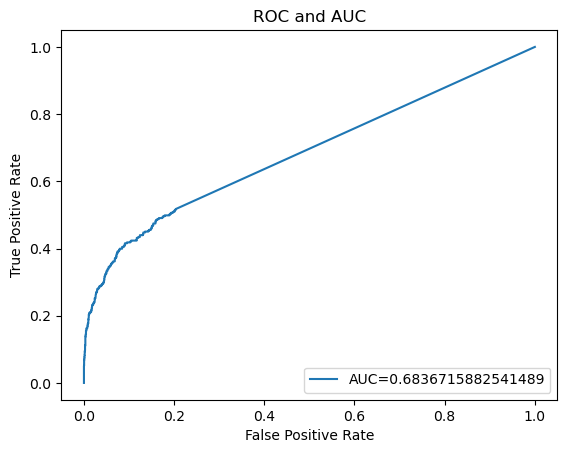

25/25 [==============================] - 0s 910us/step
Test ROC:


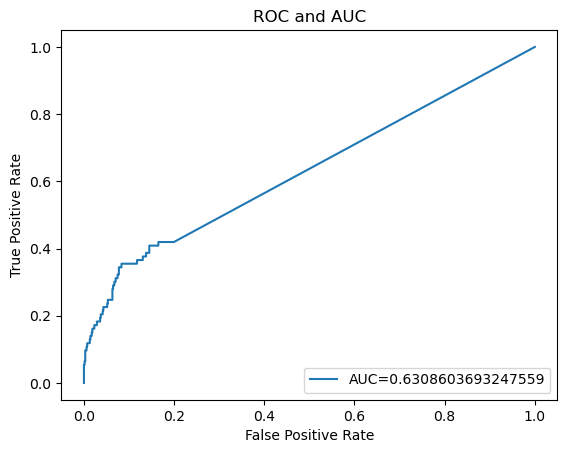

Confusion Matrix:
[[643  54]
 [ 61  32]]

True Positive: 32
True Negative: 643
False Positive: 54
False Negative: 61

Accuracy: 0.8544303797468354
True-Positve Rate: 0.34408602150537637
F1 score: 0.3575418994413408

Total Confusion Matrix:
[[872 161]
 [160 214]]

Accuracy: 0.7718550106609808
True-Positve Rate: 0.5721925133689839
F1 score: 0.5714285714285715


In [112]:
piePred = NNTree(xtrain, xtrain2, xtest, xtest2)

In [113]:
test.loc[list(xtest.index), "PiePred"] = piePred[0]

In [114]:
test.loc[list(xtest2.index), "PiePred"] = piePred[1]

Confusion Matrix:
[[131   0]
 [  0  72]]

True Positive: 72
True Negative: 131
False Positive: 0
False Negative: 0

Accuracy: 1.0
True-Positve Rate: 1.0
F1 score: 1.0
Starting Model Training
Model Training Finished
Training ROC:
154/154 [==============================] - 0s 1ms/step


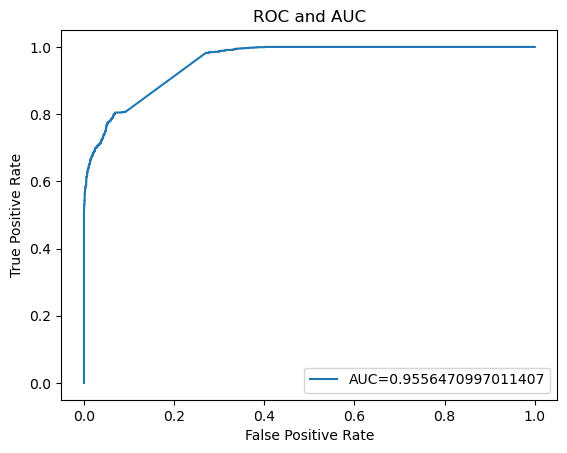

38/38 [==============================] - 0s 971us/step
Test ROC:


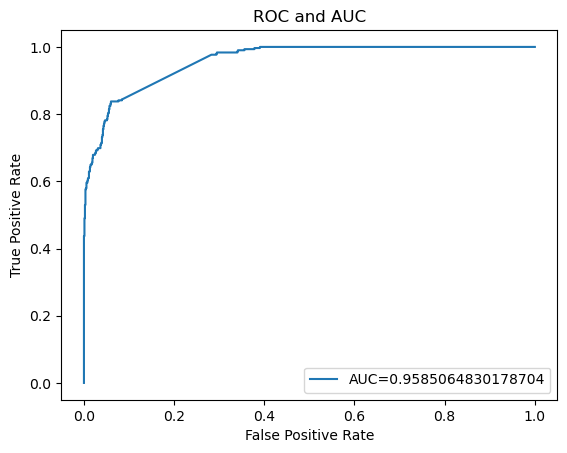

Confusion Matrix:
[[849  53]
 [ 51 251]]

True Positive: 251
True Negative: 849
False Positive: 53
False Negative: 51

Accuracy: 0.9136212624584718
True-Positve Rate: 0.8311258278145696
F1 score: 0.8283828382838284

Total Confusion Matrix:
[[980  53]
 [ 51 323]]

Accuracy: 0.9260838663823738
True-Positve Rate: 0.8636363636363636
F1 score: 0.8613333333333334


In [115]:
PerfectPred = NNTree(HTP, notHTP, HTPTest, notHTPTest)

In [119]:
test.loc[list(HTPTest.index), "PerfectPred"] = PerfectPred[0]
test.loc[list(notHTPTest.index), "PerfectPred"] = PerfectPred[1]

In [120]:
HTPPRED = MakeNN(DF_HTP[xColumns], DF_HTP["HTP"], DF_HTP_Test[xColumns], DF_HTP_Test["HTP"])

DF_HTP_Test["predHTP"] = HTPPRED[2]

xtest = DF_HTP_Test[DF_HTP_Test["predHTP"] == 1]
xtest2 = DF_HTP_Test[DF_HTP_Test["predHTP"] == 0]

44/44 [==============================] - 0s 783us/step
Confusion Matrix:
[[972 232]
 [ 94 109]]

True Positive: 109
True Negative: 972
False Positive: 232
False Negative: 94

Accuracy: 0.7683013503909026
True-Positve Rate: 0.5369458128078818
F1 score: 0.400735294117647


Confusion Matrix:
[[136   7]
 [193   5]]

True Positive: 5
True Negative: 136
False Positive: 7
False Negative: 193

Accuracy: 0.41348973607038125
True-Positve Rate: 0.025252525252525252
F1 score: 0.04761904761904762
Starting Model Training
Model Training Finished
Training ROC:
154/154 [==============================] - 0s 961us/step


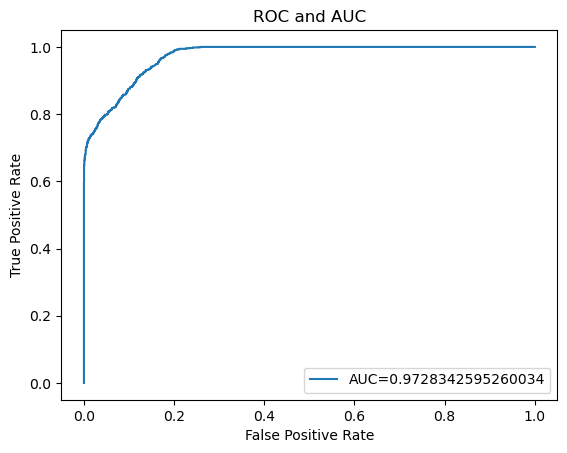

34/34 [==============================] - 0s 1ms/step
Test ROC:


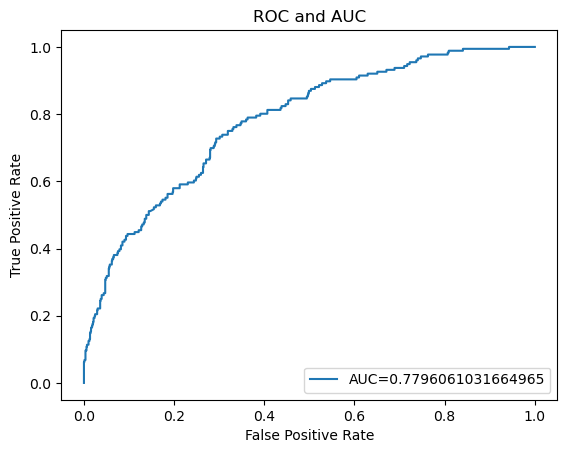

Confusion Matrix:
[[809  81]
 [101  75]]

True Positive: 75
True Negative: 809
False Positive: 81
False Negative: 101

Accuracy: 0.8292682926829268
True-Positve Rate: 0.42613636363636365
F1 score: 0.4518072289156627

Total Confusion Matrix:
[[945  88]
 [294  80]]

Accuracy: 0.728500355366027
True-Positve Rate: 0.21390374331550802
F1 score: 0.2952029520295203


In [121]:
HTPNN = NNTree(HTP, notHTP, xtest, xtest2)

In [122]:
test.loc[list(xtest.index), "HTPNN"] = HTPNN[0]
test.loc[list(xtest2.index), "HTPNN"] = HTPNN[1]

In [124]:
numMissed = abs(test["Churn_Yes"] - test["Class"])

for i in ["NNPred", "notHTPPred", "PiePred", "PerfectPred", "HTPNN"]:
    numMissed += abs(test["Churn_Yes"] - test[i])




In [125]:
test["numMissed"] = numMissed

In [126]:
test.sort_values(by='numMissed')
test.loc[DF_HTP_Test.index, "HTP"] = DF_HTP_Test["HTP"]

C:\Users\21sla\AppData\Local\Temp\ipykernel_2680\1653204367.py:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  test.loc[DF_HTP_Test.index, "HTP"] = DF_HTP_Test["HTP"]


In [127]:
for i in range(0,7):
    print("Number of sample units missed", i, "times:", len(test[test['numMissed'] == i]))
    print("Number of sample units also HTP:", len(test[(test['numMissed'] == i) & (test['HTP'] == 1)]))
    print("________________________________________")

Number of sample units missed 0 times: 759
Number of sample units also HTP: 0
________________________________________
Number of sample units missed 1 times: 221
Number of sample units also HTP: 0
________________________________________
Number of sample units missed 2 times: 99
Number of sample units also HTP: 0
________________________________________
Number of sample units missed 3 times: 93
Number of sample units also HTP: 38
________________________________________
Number of sample units missed 4 times: 123
Number of sample units also HTP: 89
________________________________________
Number of sample units missed 5 times: 94
Number of sample units also HTP: 76
________________________________________
Number of sample units missed 6 times: 18
Number of sample units also HTP: 0
________________________________________


In [128]:
test[test['numMissed'] == 4]

,tenure,MonthlyCharges,TotalCharges,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,...,Churn_Yes,Prob,Class,NNPred,notHTPPred,PiePred,PerfectPred,HTPNN,numMissed,HTP
3469,15,91.50,1400.30,0,1,0,0,1,0,0,...,0,0.775030,1,1,1,1.0,0.0,0.0,4.0,1
2173,4,86.05,308.10,1,0,0,0,1,0,0,...,0,0.647251,1,1,1,1.0,0.0,0.0,4.0,1
4042,5,51.35,262.30,1,0,0,0,1,0,0,...,0,0.437510,1,1,1,0.0,1.0,0.0,4.0,0
4322,2,70.15,123.80,0,0,0,0,1,0,0,...,0,0.688229,1,1,1,1.0,0.0,0.0,4.0,1
6081,1,49.80,49.80,1,0,0,0,1,0,0,...,0,0.301469,0,1,0,1.0,1.0,1.0,4.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6727,13,45.30,528.45,0,1,1,0,0,1,0,...,0,0.665777,1,1,1,1.0,0.0,0.0,4.0,1
5025,6,69.80,377.85,1,0,1,1,1,0,0,...,0,0.610872,1,1,1,1.0,0.0,0.0,4.0,1
4444,3,19.85,63.75,0,0,0,0,1,0,0,...,1,0.178144,0,0,0,1.0,1.0,0.0,4.0,1
1628,30,90.05,2627.20,0,1,1,0,1,0,1,...,0,0.634613,1,1,1,1.0,0.0,0.0,4.0,1


In [105]:
import time

# Record the start time
start_time = time.time()

print("--------------------Neural Network--------------------")
res = MakeNN(DF_HTP[xColumns], DF_HTP["HTP"], DF_HTP_Test[xColumns], DF_HTP_Test["HTP"])

# Record the end time
end_time = time.time()

# Calculate the duration
duration = end_time - start_time
print(f"Execution time: {duration:.4f} seconds")

--------------------Neural Network--------------------


KeyboardInterrupt: 

In [ ]:
# Record the start time
start_time = time.time()

x = DF_HTP[xColumns]
xtest = DF_HTP_Test[xColumns]
y = DF_HTP["HTP"]
ytest = DF_HTP_Test["HTP"]

gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42, max_depth = 2)

gbc.fit(x,y)

print("--------------------Gradient Boost--------------------")
ypred = gbc.predict(xtest)
print("Testing:")
evaluate(ytest, ypred)

# Record the end time
end_time = time.time()

# Calculate the duration
duration = end_time - start_time
print(f"Execution time: {duration:.4f} seconds")

In [259]:
# Record the start time
start_time = time.time()

x = DF_HTP[xColumns]
xtest = DF_HTP_Test[xColumns]
y = DF_HTP["HTP"]
ytest = DF_HTP_Test["HTP"]

#Training 
model = LogisticRegression(max_iter=1000)
model.fit(x, y)

#Getting probabilities
yprob = model.predict_proba(xtest)
threshold = thresh(yprob[:, 1], ytest)
#threshold = 0.5
ypred = (yprob[:, 1] > threshold).astype(int)

# Use this
#Log results
print("--------------------Log Model--------------------")
evaluate(ytest,ypred)

# Record the end time
end_time = time.time()

# Calculate the duration
duration = end_time - start_time
print(f"Execution time: {duration:.4f} seconds")

--------------------Log Model--------------------
Confusion Matrix:
[[944 260]
 [ 87 116]]

True Positive: 116
True Negative: 944
False Positive: 260
False Negative: 87

Accuracy: 0.7533759772565742
True-Positve Rate: 0.5714285714285714
F1 score: 0.4006908462867012
Execution time: 0.3085 seconds


In [256]:
DF_HTP_Test

,tenure,MonthlyCharges,TotalCharges,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,...,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_Yes,Prob,Class,HTP,predHTP
3159,3.0,94.85,335.75,1.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.867713,1.0,1,1
4795,53.0,20.80,1021.80,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.008291,0.0,1,0
3346,2.0,84.05,186.05,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.840678,1.0,1,1
4513,72.0,92.45,6440.25,0.0,1.0,1.0,1.0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.016211,0.0,1,0
4618,4.0,94.75,422.40,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.826491,1.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5933,3.0,105.00,294.45,1.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.842136,1.0,0,1
5783,1.0,89.30,89.30,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.847102,1.0,0,1
997,4.0,94.30,424.45,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.865607,1.0,0,1
6368,2.0,94.00,181.70,1.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.868899,1.0,0,1
